# Classifying images from Fashion MNIST using feedforward neural networks

Dataset source: https://github.com/zalandoresearch/fashion-mnist
Detailed tutorial: https://jovian.ml/aakashns/04-feedforward-nn

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

## Preparing the Data

In [5]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

1.5%

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
val_size = 10_000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [7]:
batch_size = 128

In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size * 2, num_workers=4, pin_memory=True)

images.shape torch.Size([128, 1, 28, 28])


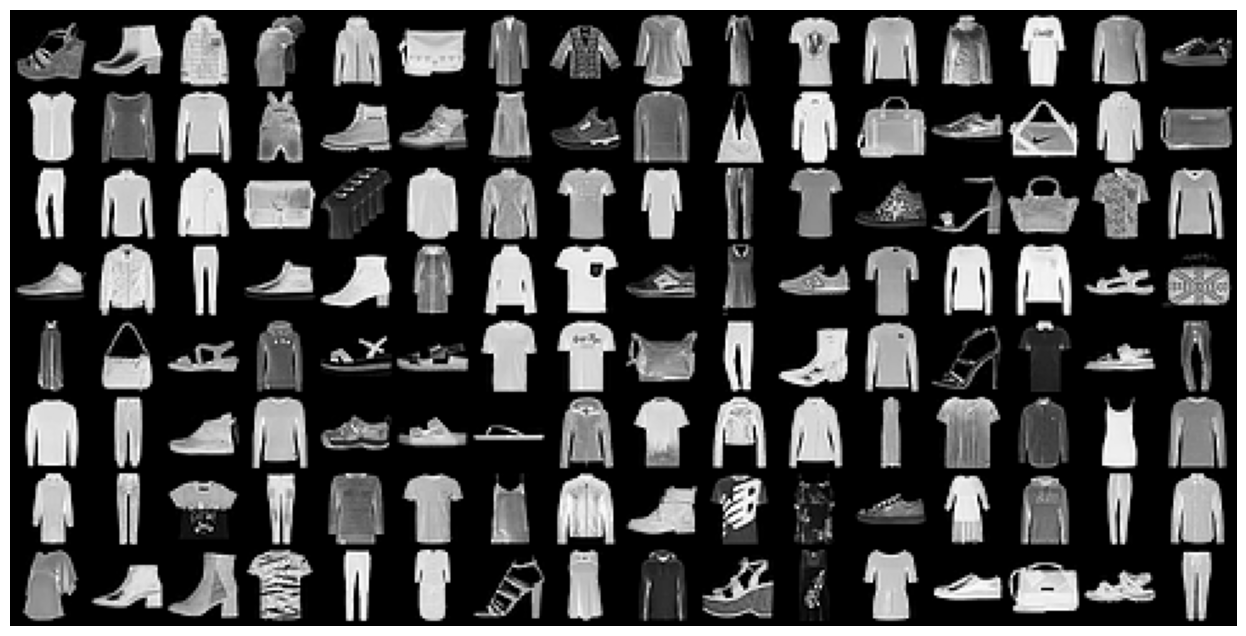

In [9]:
for images, _ in train_loader:
    print(f'images.shape {images.shape}')
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""

    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 16)
        # hidden layer2
        self.linear2 = nn.Linear(16, 32)
        #output layer
        self.linear3 = nn.Linear(32, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate the loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_loses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


## Using a GPU

In [25]:
torch.cuda.is_available()

False

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [27]:
device = get_default_device()
device

device(type='cpu')

In [28]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [29]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model

In [31]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epochs in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epochs, result)
        history.append(result)
    return history

In [32]:
input_size = 784
num_classes = 10

In [33]:
model = MnistModel(in_size=input_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [34]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3062644004821777, 'val_acc': 0.09833984076976776}]

In [35]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7548, val_acc: 0.6974
Epoch [1], val_loss: 0.6738, val_acc: 0.7015
Epoch [2], val_loss: 0.5988, val_acc: 0.7712
Epoch [3], val_loss: 0.5970, val_acc: 0.7731
Epoch [4], val_loss: 0.5705, val_acc: 0.8051


In [36]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4531, val_acc: 0.8426
Epoch [1], val_loss: 0.4449, val_acc: 0.8441
Epoch [2], val_loss: 0.4529, val_acc: 0.8421
Epoch [3], val_loss: 0.4389, val_acc: 0.8443
Epoch [4], val_loss: 0.4339, val_acc: 0.8461


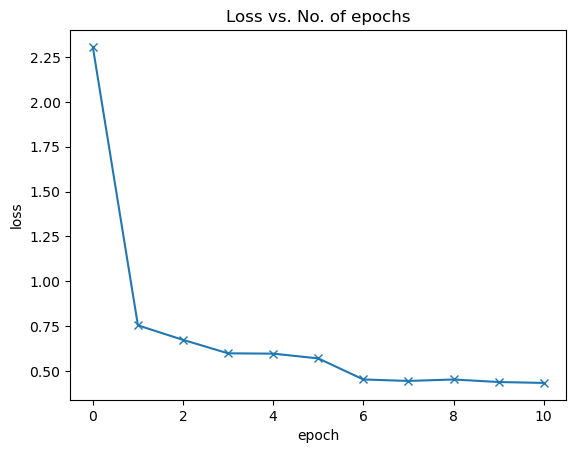

In [38]:
loss = [x['val_loss'] for x in history]
plt.plot(loss, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

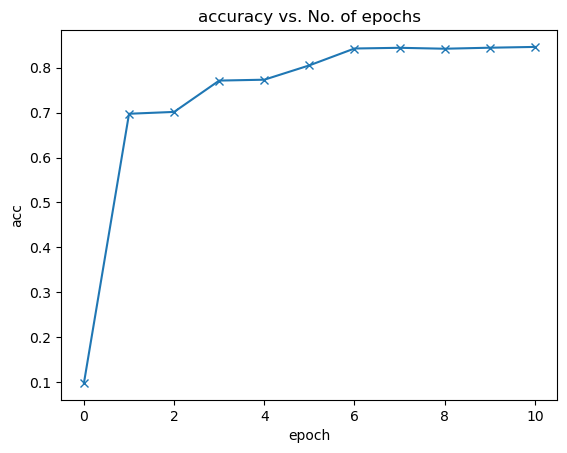

In [39]:
loss = [x['val_acc'] for x in history]
plt.plot(loss, '-x')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('accuracy vs. No. of epochs');

## Prediction on Samples

In [40]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


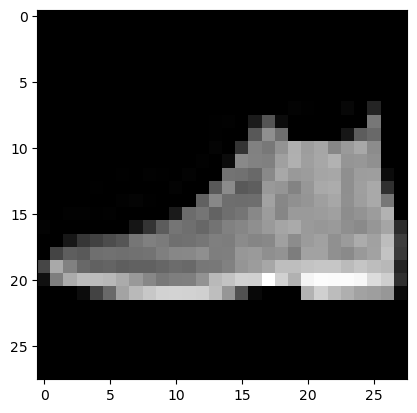

In [42]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [43]:
evaluate(model, test_loader)

{'val_loss': 0.4591272473335266, 'val_acc': 0.8368164300918579}

## Save and upload

In [44]:
saved_weights_fname = 'fashion-feedforward.pth'

In [45]:
torch.save(model.state_dict(), saved_weights_fname)